## Perform a binary classification on feature and non-feature Wikipedia articles.

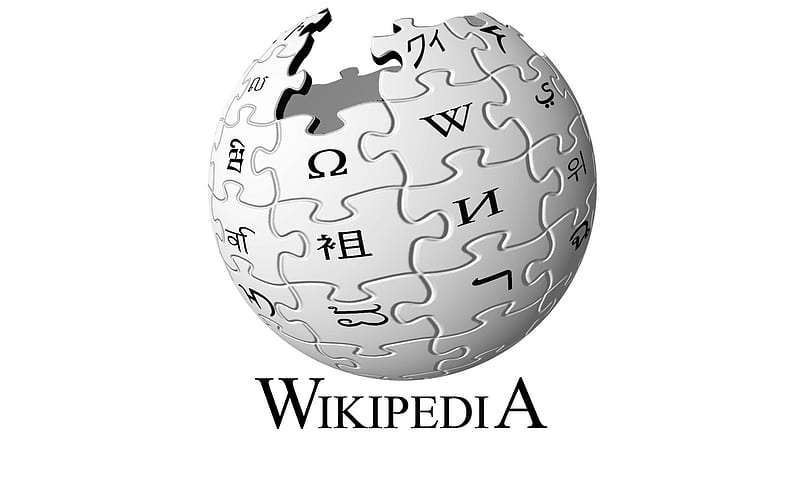

#### Installing Wikipedia API

In [1]:
pip install wikipedia-api

Note: you may need to restart the kernel to use updated packages.


#### Import the required libraries like Pandas, Numpy, Scikit-learn, and Wikipedia API.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import wikipediaapi

#### Load the provided dataset using Pandas read_csv() function.

In [16]:
df = pd.read_csv("/kaggle/input/articledesc-guvi/articleDesc.csv", delimiter='@@|@\$@', engine='python',error_bad_lines=False)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 388779: Expected 7 fields in line 388779, saw 8. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 572874: Expected 7 fields in line 572874, saw 8. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 684635: Expected 7 fields in line 684635, saw 8. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 889832: Expected 7 fields in line 889832, saw 8. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1298564: Expected 7 fields in line 1298564, saw 8. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
S

In [17]:
df.head(11)

,Article Name,Vital Article,Level,Class,Importance,Topic,Wikiproject
0,Population_history_of_ancient_Egypt_Archive_8,NaN,NaN,NaN,NaN,NaN,NaN
1,Sin_Mirar_Atrás,NaN,NaN,NaN,NaN,NaN,NaN
2,RMWFC,NaN,NaN,NaN,NaN,NaN,NaN
3,Wilbur_E._Colyer,NaN,NaN,Stub,NaN,"['biography', 'military history', 'united stat...",NaN
4,Salmson_B.9,NaN,NaN,Start,NaN,NaN,NaN
5,Campaign_to_Suppress_Bandits_in_northeastern_G...,NaN,NaN,B,NaN,NaN,NaN
6,Vatun,NaN,NaN,NaN,NaN,['fictional characters'],NaN
7,Ralph_Bean,NaN,NaN,NaN,NaN,NaN,NaN
8,Clothilde_of_France,NaN,NaN,NaN,NaN,NaN,NaN
9,USS_Lillian_Anne_(YFB-41),NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
dfa = df[['Article Name', 'Class']].copy()
dfa.head(11)

,Article Name,Class
0,Population_history_of_ancient_Egypt_Archive_8,NaN
1,Sin_Mirar_Atrás,NaN
2,RMWFC,NaN
3,Wilbur_E._Colyer,Stub
4,Salmson_B.9,Start
5,Campaign_to_Suppress_Bandits_in_northeastern_G...,B
6,Vatun,NaN
7,Ralph_Bean,NaN
8,Clothilde_of_France,NaN
9,USS_Lillian_Anne_(YFB-41),NaN


#### Create labeling using the provided dataset for each article’s name, denoting whether it is a featured article or not.

In [19]:
dfa['Label'] = dfa['Class'].apply(lambda x: 1 if x == 'FA' else 0)
Label_counts = dfa['Label'].value_counts()
print(Label_counts)

0    6147849
1       5388
Name: Label, dtype: int64


#### We need to sample the majority 'Non-FA' to balance the dataset.

In [20]:
dfa.head(11)

,Article Name,Class,Label
0,Population_history_of_ancient_Egypt_Archive_8,NaN,0
1,Sin_Mirar_Atrás,NaN,0
2,RMWFC,NaN,0
3,Wilbur_E._Colyer,Stub,0
4,Salmson_B.9,Start,0
5,Campaign_to_Suppress_Bandits_in_northeastern_G...,B,0
6,Vatun,NaN,0
7,Ralph_Bean,NaN,0
8,Clothilde_of_France,NaN,0
9,USS_Lillian_Anne_(YFB-41),NaN,0


<AxesSubplot:xlabel='Label', ylabel='count'>

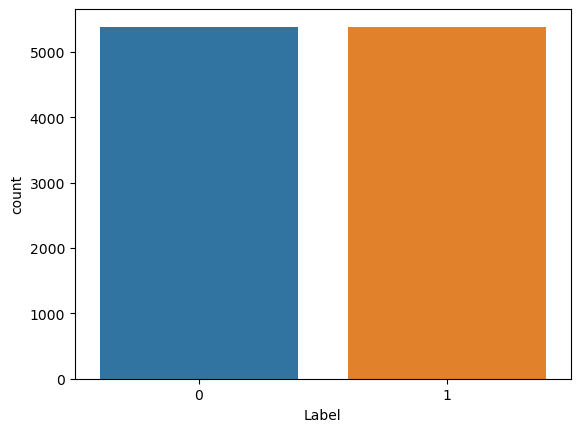

In [21]:
idx_0 = dfa.loc[dfa['Label'] == 0]
idx_1 = dfa.loc[dfa['Label'] == 1]
num = 5388
sampled_idx_0 = idx_0.sample(n=num, random_state=38)
udf = pd.concat([sampled_idx_0, idx_1])
sns.countplot(x='Label',data=udf)

In [22]:
udf.head(11)

,Article Name,Class,Label
5414172,New_Conservative_Group,Stub,0
4752706,Zamboanga_City,B,0
1562474,Emmanuel_College_(University_of_Queensland),NaN,0
2221163,Bowness_High_School,Start,0
4647640,Abronia_latifolia,Stub,0
4225985,Penberthy_Croft_Mine,Stub,0
5622176,Bank_PHB,Start,0
4169103,Detention_center,NaN,0
1722766,Lloyd_Jones_(Australian_footballer),Stub,0
2007460,Ali_Asghar_Sherdost,Stub,0


### Use the Wikipedia API to extract the article data in raw format

#### we need to select required features to extract from wikipedia. I selected some features, which will ensure the quality of wikipedia content, they are:
* Number of words in the article
* Number of sections in the article
* Number of external links in the article
* Readability score of the article 

In [4]:
pip install textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.0 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
wiki = wikipediaapi.Wikipedia('en')
import spacy
import nltk
nltk.download('punkt')
from textstat import flesch_reading_ease

# Load the English language model of spaCy
nlp = spacy.load('en_core_web_sm')

#extracting number of words in each article
def words_count(Article_Name):
    page = wiki.page(Article_Name)
    wor = nltk.word_tokenize(page.text)
    return len(wor)
    
#extracting Number of sections in the article
def num_of_sec(Article_Name):
    page = wiki.page(Article_Name)
    if page.exists():
        return len(page.sections)
    else:
        return np.nan
    
#extracting Number of links in the article
def num_of_links(Article_Name):
    page = wiki.page(Article_Name)
    if page.exists():
        return len(page.links)
    else:
        return np.nan

#extracting Readability score of the article
def Readability_score(Article_Name):
    page = wiki.page(Article_Name)
    readability = flesch_reading_ease(page.text)
    return readability

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### we create each columns in dataset and we add the resepective article features in dataset.

In [23]:
udf['words_count'] = udf['Article Name'].apply(words_count)
udf['Sections'] = udf['Article Name'].apply(num_of_sec)
udf['Links'] = udf['Article Name'].apply(num_of_links)
udf['Readability_Score'] = udf['Article Name'].apply(Readability_score)
pd2 = udf.to_excel('processed_dataset_final')

In [4]:
pd2.head(11)

,Article Name,Class,Label,words_count,Sections,Links,Readability_Score
0,New_Conservative_Group,Stub,0,238,1.0,220.0,50.57
1,Zamboanga_City,B,0,7025,15.0,713.0,51.58
2,Emmanuel_College_(University_of_Queensland),NaN,0,818,4.0,24.0,30.60
3,Bowness_High_School,Start,0,245,3.0,110.0,45.25
4,Abronia_latifolia,Stub,0,211,3.0,44.0,58.38
5,Penberthy_Croft_Mine,Stub,0,151,3.0,201.0,60.35
6,Bank_PHB,Start,0,252,6.0,39.0,57.30
7,Detention_center,NaN,0,96,1.0,12.0,10.91
8,Lloyd_Jones_(Australian_footballer),Stub,0,46,2.0,10.0,60.14
9,Ali_Asghar_Sherdost,Stub,0,93,2.0,17.0,70.70


In [5]:
pd2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10776 entries, 0 to 10775
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Article Name       10776 non-null  object 
 1   Class              9175 non-null   object 
 2   Label              10776 non-null  int64  
 3   words_count        10776 non-null  int64  
 4   Sections           10547 non-null  float64
 5   Links              10547 non-null  float64
 6   Readability_Score  10776 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 589.4+ KB


#### Initial Phase , we classified the required class to Label, so we can remove class cloumn. 

In [6]:
df2 = pd2.drop('Class', axis=1)

In [7]:
# droping unknown values
df2 = df2.dropna()

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10547 entries, 0 to 10775
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Article Name       10547 non-null  object 
 1   Label              10547 non-null  int64  
 2   words_count        10547 non-null  int64  
 3   Sections           10547 non-null  float64
 4   Links              10547 non-null  float64
 5   Readability_Score  10547 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 576.8+ KB


In [9]:
df2['Label'].value_counts()

1    5372
0    5175
Name: Label, dtype: int64

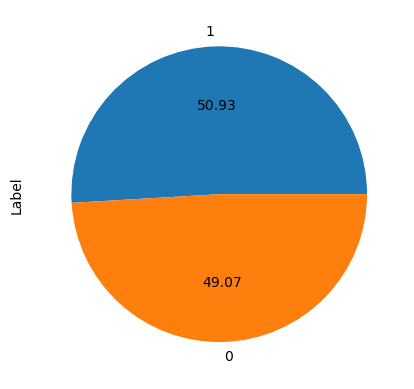

In [10]:
ap = df2['Label'].value_counts().plot.pie(autopct='%.2f')

#### Moreover, both classes has equal amount of samples. We can proceed with exploratory data anlaysis.

<AxesSubplot:>

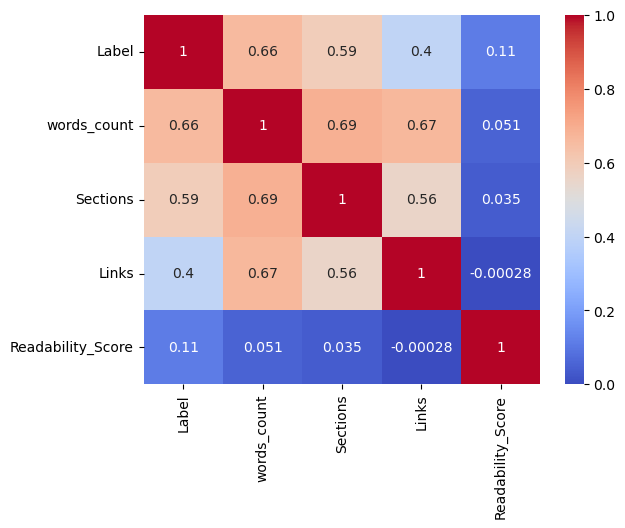

In [11]:
corr = df2.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

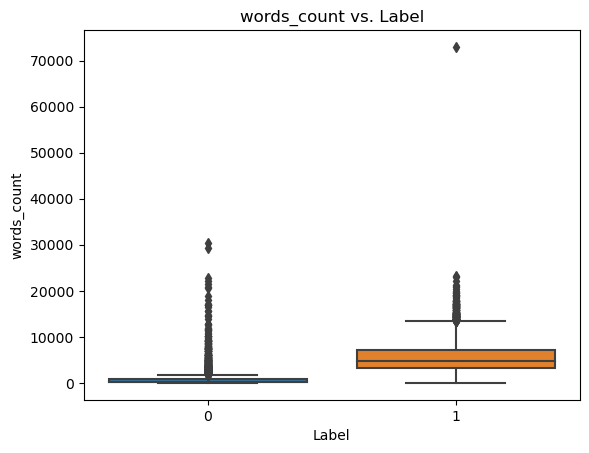

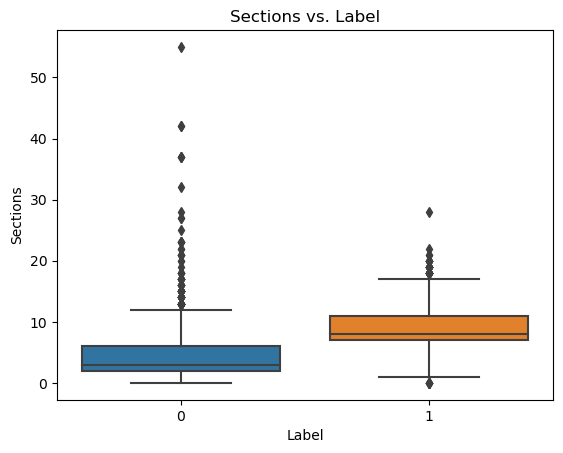

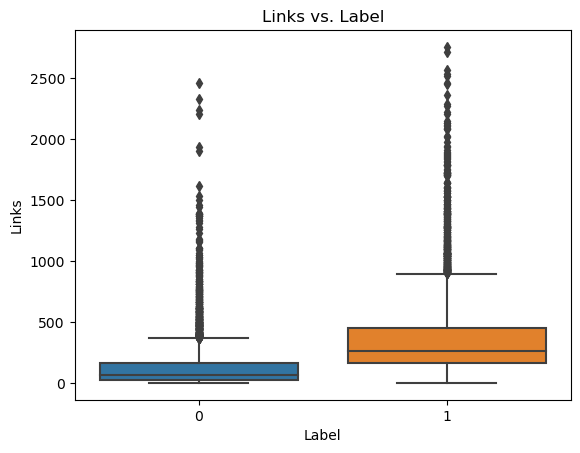

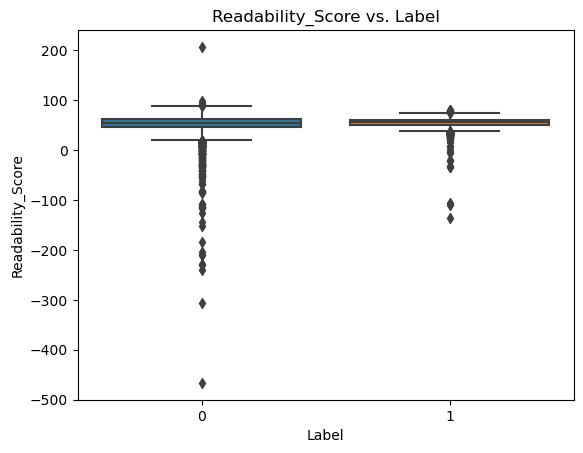

In [12]:
fea = ['words_count','Sections','Links','Readability_Score']
target = 'Label'
for feature in fea:
    fig, ax = plt.subplots()
    sns.boxplot(x=target, y=feature, data=df2, ax=ax)
    ax.set_title(f'{feature} vs. {target}')

fea = ['words_count','Sections','Links','Readability_Score']

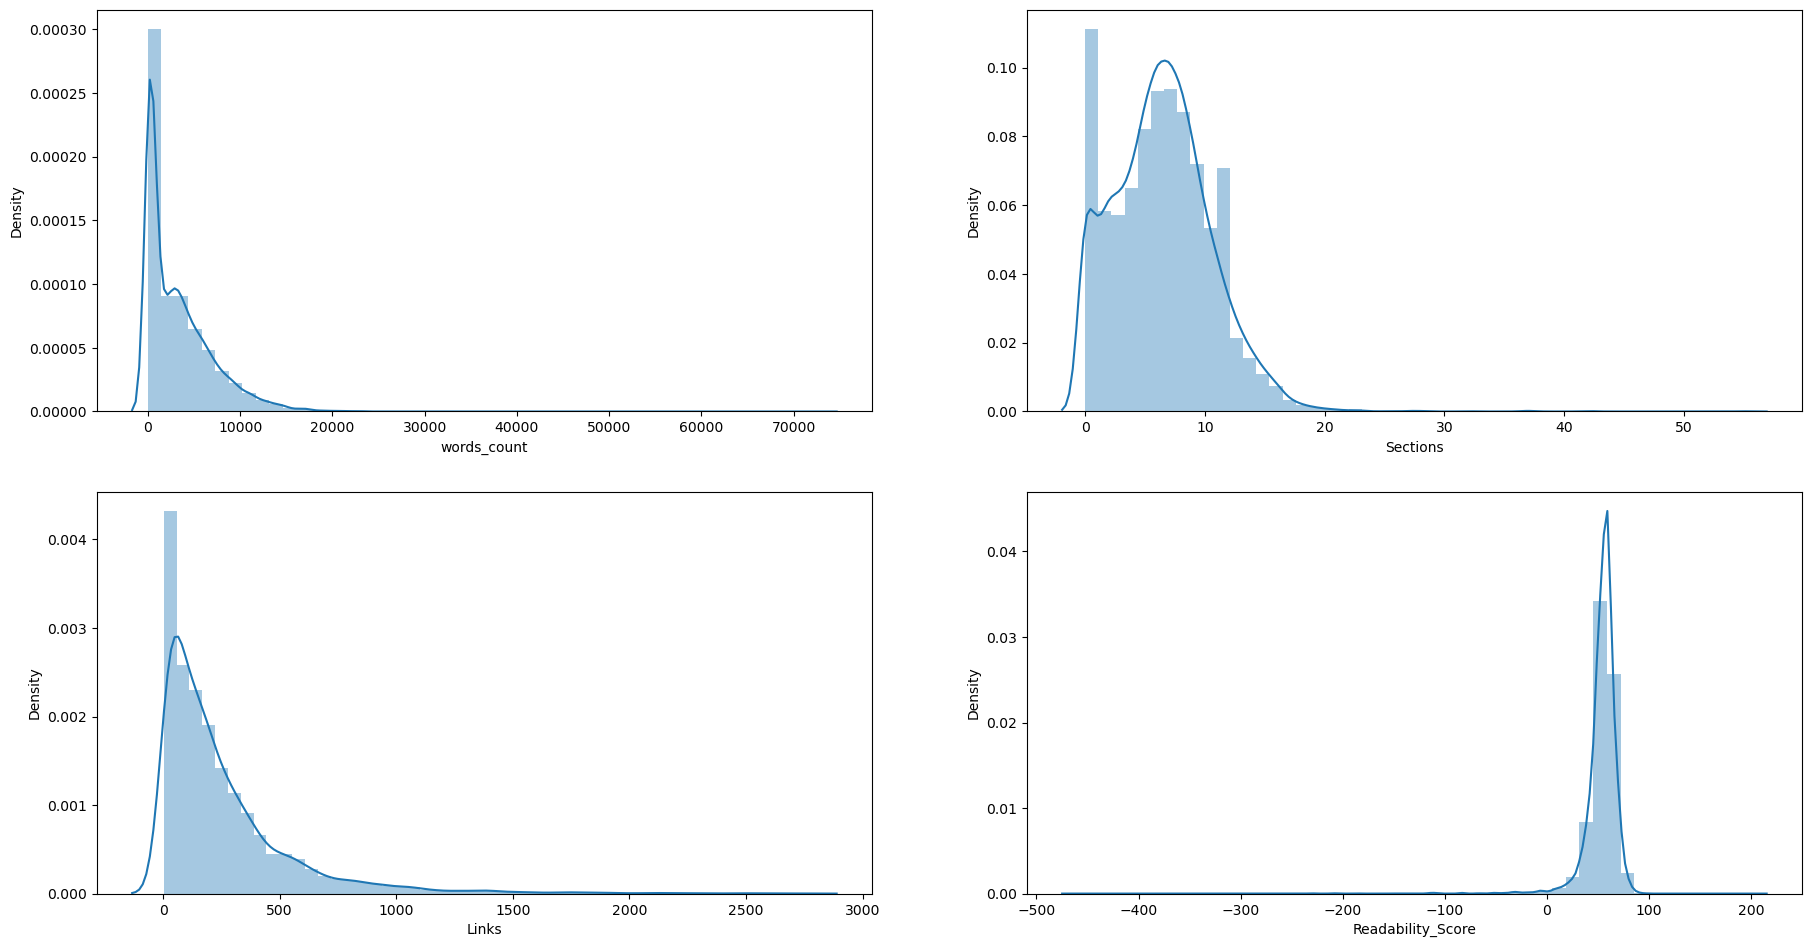

In [13]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(22,24))
plt.subplot(4,2,1)
sns.distplot(df2['words_count'])
plt.subplot(4,2,2)
sns.distplot(df2['Sections'])
plt.subplot(4,2,3)
sns.distplot(df2['Links'])
plt.subplot(4,2,4)
sns.distplot(df2['Readability_Score'])
plt.show()

#### The distribution plots shows each feature graph is right (positive) skewed except readability score .we can apply Z-Score on the normally distributed columns while IQR is on either left or right-skewed data. we will use IQR (Inter Quartile Range) to remove outliers for words_count, sections and links feature. 

In [14]:
# Calculate the IQR for each column
Q1 = df2.quantile(0.25)
Q3 = df2.quantile(0.75)
IQR = Q3 - Q1

# Remove outliers
df3 = df2[~((df2 < (Q1 - 1.6 * IQR)) | (df2 > (Q3 + 1.6 * IQR))).any(axis=1)]

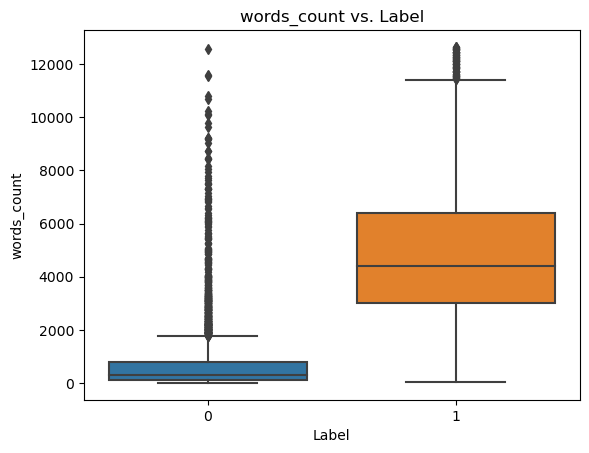

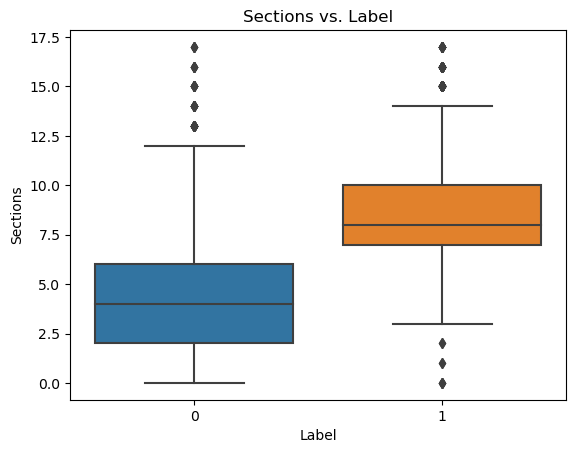

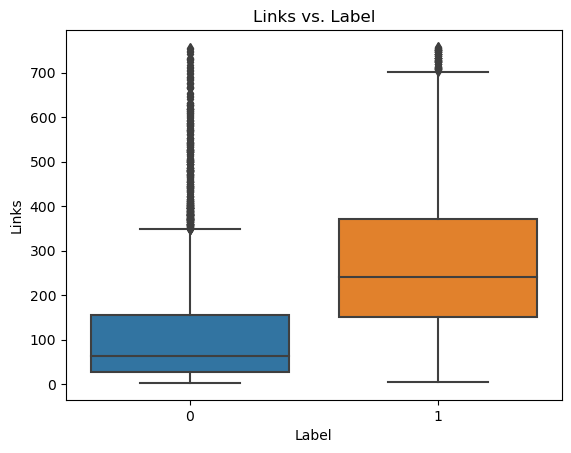

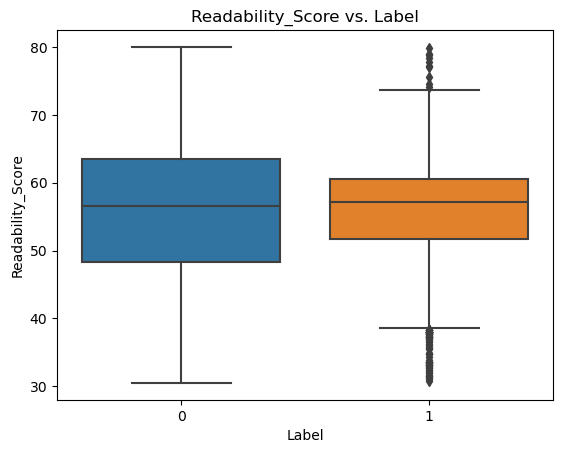

In [32]:
fea = ['words_count','Sections','Links','Readability_Score']
target = 'Label'
for feature in fea:
    fig, ax = plt.subplots()
    sns.boxplot(x=target, y=feature, data=df3, ax=ax)
    ax.set_title(f'{feature} vs. {target}')

#### After applying IQR method for removing outliers, partial outliers are removed. 

In [16]:
print(df3['Label'].value_counts())

1    4720
0    4583
Name: Label, dtype: int64


#### Creating binary classification models

#### Split the data into training and testing sets

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df3[['words_count','Sections','Links','Readability_Score']], df3['Label'], test_size=0.2, random_state=42)

#### Feature scaling is used to standardize the range of features or variables in a dataset to ensure that each feature contributes equally to the analysis, regardless of their original scales.

In [18]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

#### Logistic Regression

In [20]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
print('Logistic Regression accuracy:', acc_lr)
print()
cm_lr = confusion_matrix(y_test, y_pred_lr)
print('Confusion Matrix (Logistic Regression):\n', cm_lr)
print()
print('Classification Report (Logistic Regression):\n',classification_report(y_test,y_pred_lr))

Logistic Regression accuracy: 0.9129500268672757

Confusion Matrix (Logistic Regression):
 [[838  65]
 [ 97 861]]

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.90      0.93      0.91       903
           1       0.93      0.90      0.91       958

    accuracy                           0.91      1861
   macro avg       0.91      0.91      0.91      1861
weighted avg       0.91      0.91      0.91      1861



#### Support Vector Machine (SVM)

In [21]:
svm = SVC(kernel='linear', C=1, random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('SVM accuracy:', accuracy)
print()
cm_svm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix (SVM):\n', cm_svm)
print()
print('Classification Report (SVM):\n',classification_report(y_test,y_pred))

SVM accuracy: 0.9247716281569048

Confusion Matrix (SVM):
 [[833  70]
 [ 70 888]]

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       903
           1       0.93      0.93      0.93       958

    accuracy                           0.92      1861
   macro avg       0.92      0.92      0.92      1861
weighted avg       0.92      0.92      0.92      1861



#### Random Forest Classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 200)
rfc.fit(X_train,y_train)
pred1 = rfc.predict(X_test)
acc_rfc = accuracy_score(y_test, pred1)
print('Random Forest Classifier accuracy:', acc_rfc)
print()
cm_rfc = confusion_matrix(y_test, pred1)
print('Confusion Matrix (Random Forest Classifier):\n', cm_rfc)
print()
print('Classification Report (Random Forest Classifier):\n',classification_report(y_test,pred1))

Random Forest Classifier accuracy: 0.9376679204728641

Confusion Matrix (Random Forest Classifier):
 [[823  80]
 [ 36 922]]

Classification Report (Random Forest Classifier):
               precision    recall  f1-score   support

           0       0.96      0.91      0.93       903
           1       0.92      0.96      0.94       958

    accuracy                           0.94      1861
   macro avg       0.94      0.94      0.94      1861
weighted avg       0.94      0.94      0.94      1861



### Hence, The random forest model performed well and showed 93.76% accuracy. It is best in predicting the featured or non featured articles.

### It is an End to End Regression project, the logistic regression accuracy is 91.29% , but SVM worked little bit better than Logistic as it shown 92.47%